In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_rows', 15000)
pd.set_option('display.max_columns', 300)
from scipy.stats import ttest_ind
import warnings; warnings.simplefilter('ignore')
import matplotlib.animation as animation

In [2]:
# Import & Process USA Coronavirus numbers. 
# https://github.com/nytimes/covid-19-data/blob/master/us.csv
us_covid_df=pd.read_csv('us.csv')
us_covid_df['date']=pd.to_datetime(us_covid_df['date'])
us_covid_df['date']=us_covid_df['date'].dt.date
dates = pd.date_range(us_covid_df['date'][0], us_covid_df['date'][us_covid_df['date'].size-1], freq='2W')
x=np.array(us_covid_df['cases'])
y=np.array(us_covid_df['deaths'])
date_lables=[]
i=0
while(i<dates.size):
    date_lables.append(dates[i].month_name()[0:3] +' '+ str(dates[i].day))
    i += 1

In [3]:
def update(curr):
    if curr == x.shape[0]-1: 
        a.event_source.stop()
    plt.cla()
    plt.plot(x[:curr],linewidth=2,label='Cases')
    plt.plot(y[:curr],linewidth=2,color='r',label='Deaths')
    plt.axis([0,x.shape[0],0,np.max(x)]) #(x,x, y,y)
    plt.gca().set_title('COVID-19 in the U.S.')
    plt.gca().set_xlabel('Days since Jan 21st')
    plt.gca().set_xticks(np.arange(0,len(us_covid_df),14))
    plt.gca().set_yticks(np.arange(0,np.max(x),100000))
    plt.gca().set_xticklabels(date_lables)
    plt.xticks(rotation=45)
    plt.legend(['Cases', 'Deaths'],loc='upper center',shadow=True)
    plt.annotate('Day {}'.format(curr), [x.shape[0]*.65,np.max(x)*0.87])
    plt.grid(axis='y')  

<IPython.core.display.Javascript object>


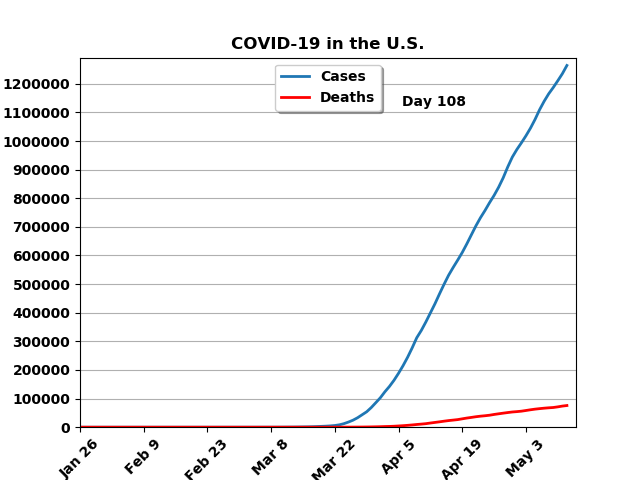

In [4]:
fig = plt.figure()
a = animation.FuncAnimation(fig,update,interval=100)

In [5]:
def cleanData(row):
    row['Pre-Existing Condition'] = re.sub(r'\s\(.*\)\W*','',row['Pre-Existing Condition'])
    row['Pre-Existing Condition'] = re.sub(r'\*','',row['Pre-Existing Condition'])
    row['Pre-Existing Condition'] = re.sub(' disease','',row['Pre-Existing Condition'])
    row['Pre-Existing Condition'] = row['Pre-Existing Condition'][0:20]
    row['Pre-Existing Condition'] = re.sub('( co)','',row['Pre-Existing Condition'])
    row['Pre-Existing Condition'] = re.sub('\,','',row['Pre-Existing Condition'])
    row['Hospitalized, non-ICU'] = re.sub(r'\s\(.*\)','',row['Hospitalized, non-ICU'])
    row['ICU admission'] = re.sub(r'\s\(.*\)','',row['ICU admission'])
    return row

In [6]:
# Find Hospitalized COVID cases by Pre-Existing conditions
http_cdc_preliminary=pd.read_html('https://www.cdc.gov/mmwr/volumes/69/wr/mm6913e2.htm',header=1)
cdc_preliminary_first=http_cdc_preliminary[0].copy()
cdc_preliminary_first.rename(columns={'Underlying health condition/Risk factor for severe outcomes from respiratory infection (no., % with condition)': 
                     'Pre-Existing Condition'},inplace=True)
cdc_preliminary=cdc_preliminary_first[['Pre-Existing Condition','Hospitalized, non-ICU','ICU admission']]
cdc_preliminary.drop(index=[0,1,2,3],inplace=True)
cdc_preliminary.apply(cleanData,axis=1)
cdc_preliminary['Hospitalized, non-ICU'] = cdc_preliminary['Hospitalized, non-ICU'].astype(int) #first way
cdc_preliminary['ICU admission'] =pd.to_numeric(cdc_preliminary['Hospitalized, non-ICU']) #second way
cdc_preliminary['Number Hospitalized']=cdc_preliminary['Hospitalized, non-ICU'] + cdc_preliminary['ICU admission']
cdc_preliminary.drop(['Hospitalized, non-ICU','ICU admission'],axis=1,inplace=True)
cdc_preliminary.reset_index(inplace=True)
cdc_preliminary.drop('index',axis=1,inplace=True)
cdc_preliminary.iloc[8,1] = cdc_preliminary.iloc[8,1] + cdc_preliminary.iloc[11,1]
cdc_preliminary.drop(index=[11],inplace=True)

# Data available at https://gis.cdc.gov/grasp/COVIDNet/COVID19_5.html
cdc_lab_confirmed=pd.read_csv('Medical_Conditions.csv',header=1,usecols=[1,2,4])
cdc_lab_confirmed['Number Hospitalized']=cdc_lab_confirmed['CHILDREN-COUNT'] + cdc_lab_confirmed['ADULTS-COUNT']
cdc_lab_confirmed.drop(['ADULTS-COUNT','CHILDREN-COUNT'],axis=1,inplace=True)
cdc_lab_confirmed.at[12,'MEDICAL CONDITION']= 'GI disease'
cdc_lab_confirmed['Pre-Existing Condition']=cdc_lab_confirmed.apply(lambda x: re.sub(' disease','', x['MEDICAL CONDITION']), axis=1);
cdc_lab_confirmed.drop(['MEDICAL CONDITION'],axis=1,inplace=True)
cdc_lab_confirmed=cdc_lab_confirmed[['Pre-Existing Condition','Number Hospitalized']].copy()
cdc_lab_confirmed.dropna(inplace=True)
cdc_lab_confirmed.reset_index(inplace=True)
cdc_lab_confirmed.drop(['index'],axis=1,inplace=True)
cdc_lab_confirmed

cdc_hospitalized_comorbidity = pd.concat([cdc_preliminary,cdc_lab_confirmed]).sort_values('Number Hospitalized')
cdc_hospitalized_comorbidity.drop_duplicates('Pre-Existing Condition',keep='last', inplace=True)
cdc_hospitalized_comorbidity.set_index('Pre-Existing Condition',inplace=True)
cdc_hospitalized_comorbidity.drop(['Other'],axis=0,inplace=True)
#cdc_hospitalized_comorbidity

<IPython.core.display.Javascript object>


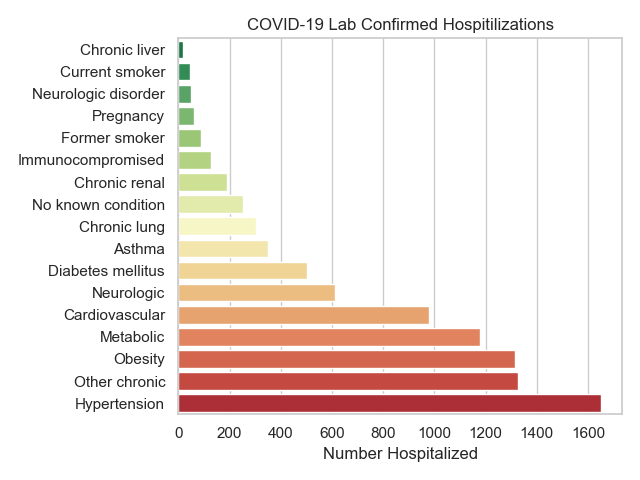

In [10]:
#plot using seaborn
import seaborn as sns
fig=plt.figure()
plt.gca().set_title('COVID-19 Lab Confirmed Hospitilizations')
sns.set(style="whitegrid")
seq_col_brew = sns.color_palette("RdYlGn_r",n_colors=cdc_hospitalized_comorbidity.shape[0]) #http://jose-coto.com/styling-with-seaborn
sns.set_palette(seq_col_brew)
sns.barplot(cdc_hospitalized_comorbidity['Number Hospitalized'],cdc_hospitalized_comorbidity.index)
axes=plt.gca()
axes.set_ylabel('')
#plt.grid(axis='y')
plt.tight_layout() 
plt.savefig('covid-19.png')